<h1 align="center">Autoencoders Solution </h1> 
<br><br>
 <br><br>

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import numpy as np

import tensorflow as tf
#!pip install --upgrade tensorflow-probability
import tensorflow_probability as tfp

#3D plot
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import norm
tf.config.experimental.set_visible_devices([], 'GPU')

In [2]:
def dis_img(x,y, labeldict, title = None):
    
    indx = np.random.choice(range(x.shape[0]) , 16 )   
    fig, ax = plt.subplots(4, 4,
                           figsize=(6,5),
                           subplot_kw={'xticks': [], 'yticks': []},
                           num= title ) 
    fig.subplots_adjust(hspace=.4, wspace=0)
    imag = [ (x[ind],y[ind])  for ind in indx] 
    for coef, ax in zip(imag, ax.ravel()):
        ax.imshow(coef[0].reshape(28, 28), cmap=plt.cm.gray)     
        ax.set_title(labeldict[coef[1]])

# Precprocessing

Train-data shape:  (15000, 28, 28)
Test-data shape:  (2000, 28, 28)


<IPython.core.display.Javascript object>


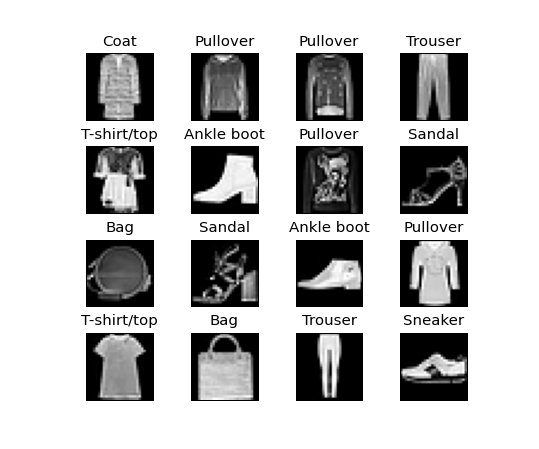

In [3]:
train = np.load('fashion_train.npz')
test = np.load('fashion_test.npz')


x_train, y_train = train['x'], train['y']
x_test, y_test = test['x'], test['y']

print('Train-data shape: ', x_train.shape)
print('Test-data shape: ', x_test.shape)



labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


x_train = x_train.reshape(-1, 784).astype('float32') /255.
x_test = x_test.reshape(-1, 784).astype('float32') /255.

# Corrupting the data data
"""
x_train = x_train +  0.4 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test = x_test +  0.4 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
#"""

dis_img(x_test,y_test, labeldict,'random_samples')



<h1 align="center">Autoencoder </h1> 
 



In [4]:
class DAE(tf.keras.Model):
    #subclassing the Model class
    Default = {'encod_size':  [100,50,3],
               'decod_size': [50,100],
               'inp_shape': 784,
               'act_fun': 'relu', 
               'batch_size': 200,
               'l2' : 0.
               }
    
    def __init__(self, hyper_p):
        super(DAE, self).__init__()
        self.__dict__.update(self.Default, **hyper_p )
        
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()       
            
          
        
    def make_encoder(self):
        inp = tf.keras.Input(self.inp_shape)
        x = inp
        x = tf.keras.layers.Dropout(0.2)(x) #Adding noise to input 
        for lay in self.encod_size:
            x = tf.keras.layers.Dense(lay, 
                                       kernel_regularizer =tf.keras.regularizers.l2(self.l2),
                                      activation = self.act_fun)(x)
        return tf.keras.models.Model(inp, x, name= 'Encoder')
        
        
    def make_decoder(self):
        inp = tf.keras.Input(self.encod_size[-1])
        x = inp
        for lay in self.decod_size:            
            x = tf.keras.layers.Dense(lay, 
                                       kernel_regularizer =tf.keras.regularizers.l2(self.l2),
                                      activation = self.act_fun)(x)
        output = tf.keras.layers.Dense(self.inp_shape,
                                       activation= 'sigmoid', name='output')(x)
        
        return tf.keras.models.Model(inp, output, name= 'Decoder')
        
    def call(self, inputs):
        #specify the model's forward pass
        z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed
    
    

In [5]:
%%time
hyp_param ={ 'inp_shape': x_train.shape[1],
             'encod_size' : [50, 3],
             'decod_size':  [50],
             'l2':1e-4,
             'act_fun': 'linear',
             'batch_size' : 100,
             'epochs' : 50,
             'learning_rate' : 1e-4
}



ae = DAE(hyp_param)

ae.compile(optimizer=tf.keras.optimizers.Adam(lr=hyp_param['learning_rate']),              
            loss =tf.keras.losses.binary_crossentropy)


history_ae = ae.fit(x_train,
                 x_train,
                 batch_size=hyp_param['batch_size'],
                 epochs=hyp_param['epochs'],
                 validation_split = 0.3,
                 shuffle= True,
                 verbose=0)

CPU times: user 1min 5s, sys: 6.98 s, total: 1min 12s
Wall time: 31.2 s


In [6]:
print(ae.summary())
print(ae.decoder.summary())


Model: "dae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Model)              (None, 3)                 39403     
_________________________________________________________________
Decoder (Model)              (None, 784)               40184     
Total params: 79,587
Trainable params: 79,587
Non-trainable params: 0
_________________________________________________________________
None
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                200       
_________________________________________________________________
output (Dense)               (None, 784)               39984     
Total params: 40,184
Trainable params

<IPython.core.display.Javascript object>


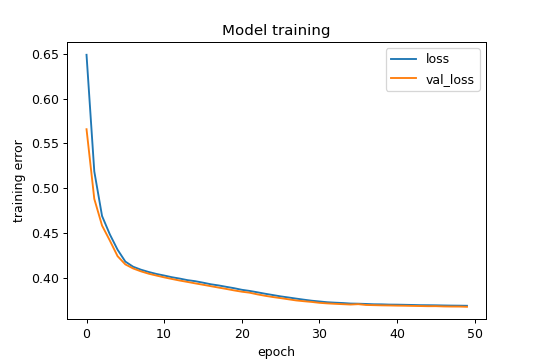

In [7]:
plt.figure('Training AE', figsize=(6,4))
for k in history_ae.history.keys():
    plt.plot(history_ae.history[k], label = k)
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


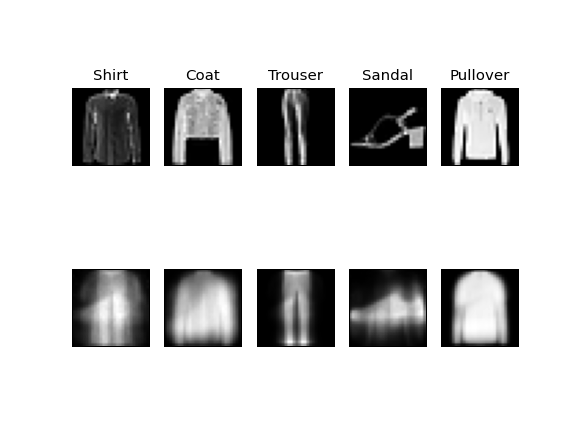

In [8]:
x_hat = ae(x_test).numpy()

index = np.random.choice(2000,  5)

fig, ax = plt.subplots(2, 5, num = 'Autoenocder reconstruction',
                       subplot_kw={'xticks': [], 'yticks': []})

for i, ind in enumerate(index):
    ax[0,i].imshow(x_test[ind].reshape(28,28), cmap='gray')
    ax[0,i].set_title(labeldict[y_test[ind]])
    ax[1,i].imshow(x_hat[ind].reshape(28,28), cmap='gray')
    

<IPython.core.display.Javascript object>


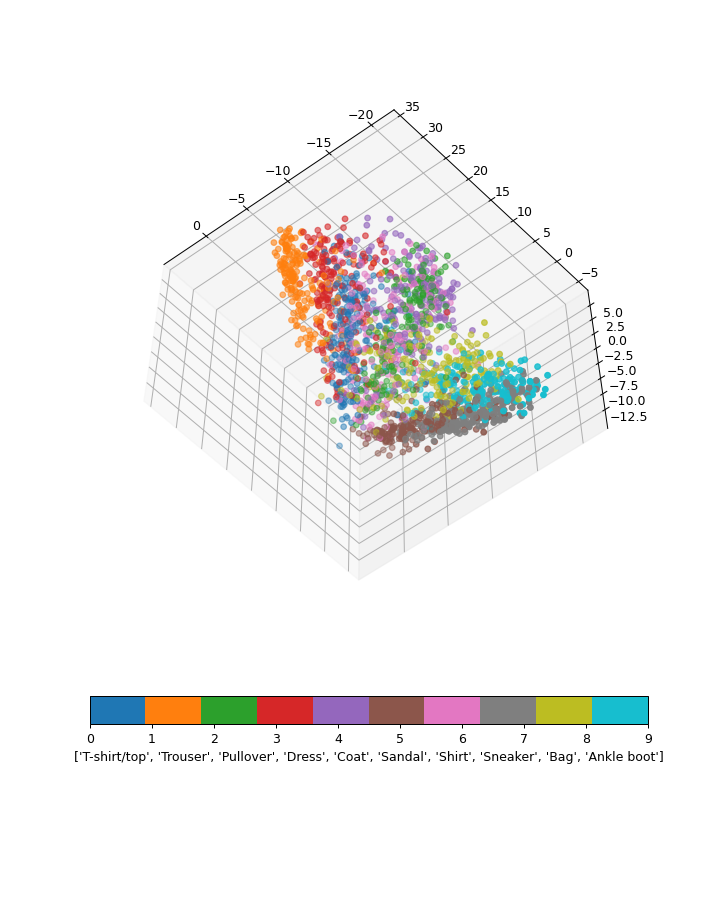

In [9]:
z = ae.encoder(x_test)

fig = plt.figure('latent space AE', figsize=(8,10))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c = y_test, cmap = 'tab10')

cbar = plt.colorbar(p, orientation='horizontal' )
cbar.set_label(list(labeldict.values()))

<h1 align="center">Variational autoencoder </h1> 
 

In [10]:
class VAE(tf.keras.Model):
    #subclassing the Model class
    Default = {'encod_size':  None,
               'decod_size': None,
               'inp_shape':None,
               'act_fun': 'relu', 
               'batch_size': 200,
               'l2' : 0
               }
    
    def __init__(self, hyper_p):
        super(VAE, self).__init__()
        self.__dict__.update(self.Default, **hyper_p )
        
        #prior
        self.p_z = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(self.encod_size[-1]))
        
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()                  
    
    def posterior(self, args):
        z_mu , z_var = args
        return tfp.distributions.MultivariateNormalDiag(loc = z_mu , scale_diag= z_var ) 
            
    def make_encoder(self):
        inp = tf.keras.Input(self.inp_shape)
        x = inp
        
        for lay in self.encod_size[:-1]:
            x = tf.keras.layers.Dense(lay, 
                                       kernel_regularizer =tf.keras.regularizers.l2(self.l2),
                                      activation = self.act_fun)(x)
        z_mu = tf.keras.layers.Dense(self.encod_size[-1], activation = 'linear')(x)
        z_var = tf.keras.layers.Dense(self.encod_size[-1], activation = 'softplus')(x)
        
        return tf.keras.models.Model(inp, [z_mu, z_var], name= 'Encoder')
        
        
    def make_decoder(self):
        inp = tf.keras.Input(self.encod_size[-1])
        x = inp
        for lay in self.decod_size:
            
            x = tf.keras.layers.Dense(lay,
                                      kernel_regularizer =tf.keras.regularizers.l2(self.l2),
                                      activation = self.act_fun)(x)
            
        # output =  tf.keras.layers.Dense(self.inp_shape,  activation = 'sigmoid', name='output')(x)   
        logits = tf.keras.layers.Dense(self.inp_shape, name='output')(x)
        output = tfp.layers.IndependentBernoulli(self.inp_shape, tfp.distributions.Bernoulli.logits)(logits)
        
        return tf.keras.models.Model(inp, output, name= 'Decoder')
        
    def call(self, inputs): 
        
        z_mu, z_var = self.encoder(inputs)
        q_z = self.posterior([z_mu, z_var])
        z = q_z.sample()
        
        self.kl =  (q_z.log_prob(z) - self.p_z.log_prob(z))
        
        reconstructed = self.decoder(z)
        return reconstructed

    
    def total_loss(self, x, x_v):
        
        #ll = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_v, labels=x))
        ll = - x_v.log_prob(x)
        return tf.reduce_mean( ll + self.kl)




In [11]:
%%time
hyp_param ={ 'inp_shape': x_train.shape[1],
             'encod_size' : [50, 2],
             'decod_size':  [ 50],
             'l2':1e-2,
             'act_fun': 'relu',
             'batch_size' : 32,
             'epochs' : 50,
             'learning_rate' : 1e-4
}



vae = VAE(hyp_param)

vae.compile(optimizer=tf.keras.optimizers.Adam(lr=hyp_param['learning_rate']),              
            loss = vae.total_loss)


history_vae = vae.fit(x_train,
                 x_train,
                 batch_size=hyp_param['batch_size'],
                 epochs=hyp_param['epochs'],
                 validation_split = 0.3,
                 shuffle= True,
                 verbose=0)


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
CPU times: user 1min 42s, sys: 14.4 s, total: 1min 57s
Wall time: 44.4 s


Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50)           39250       input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            102         dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            102         dense_3[0][0]                    
Total params: 39,454
Trainable params: 39,454
Non-trainable params: 0
______________________

<IPython.core.display.Javascript object>


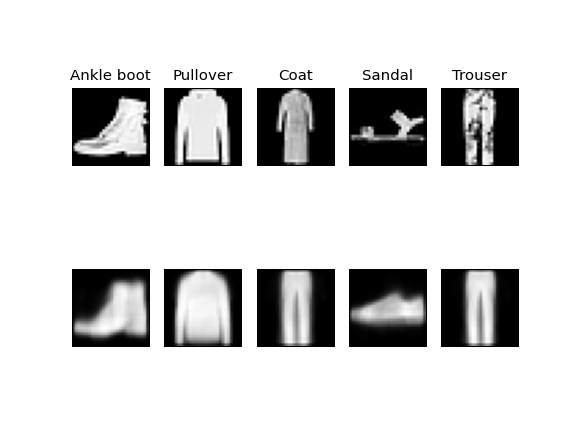

In [12]:
vae.encoder.summary()

x_hat = vae(x_test).mean().numpy()

index = np.random.choice(2000,  5)

fig, ax = plt.subplots(2, 5, num = 'Variational autoenocder reconstruction',
                       subplot_kw={'xticks': [], 'yticks': []})

for i, ind in enumerate(index):
    ax[0,i].imshow(x_test[ind].reshape(28,28), cmap='gray')
    ax[0,i].set_title(labeldict[y_test[ind]])
    ax[1,i].imshow(x_hat[ind].reshape(28,28), cmap='gray')

<IPython.core.display.Javascript object>


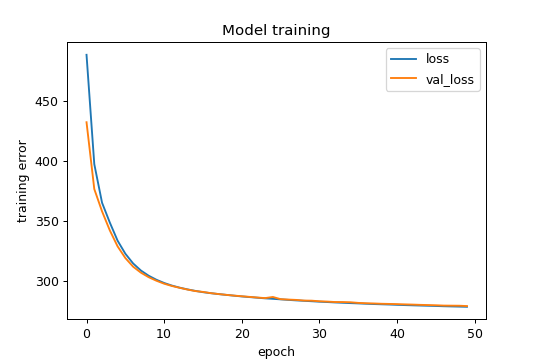

In [13]:
plt.figure('Training VAE', figsize=(6,4))
for k in history_vae.history.keys():
    plt.plot(history_vae.history[k], label = k)
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(loc='upper right')


<IPython.core.display.Javascript object>


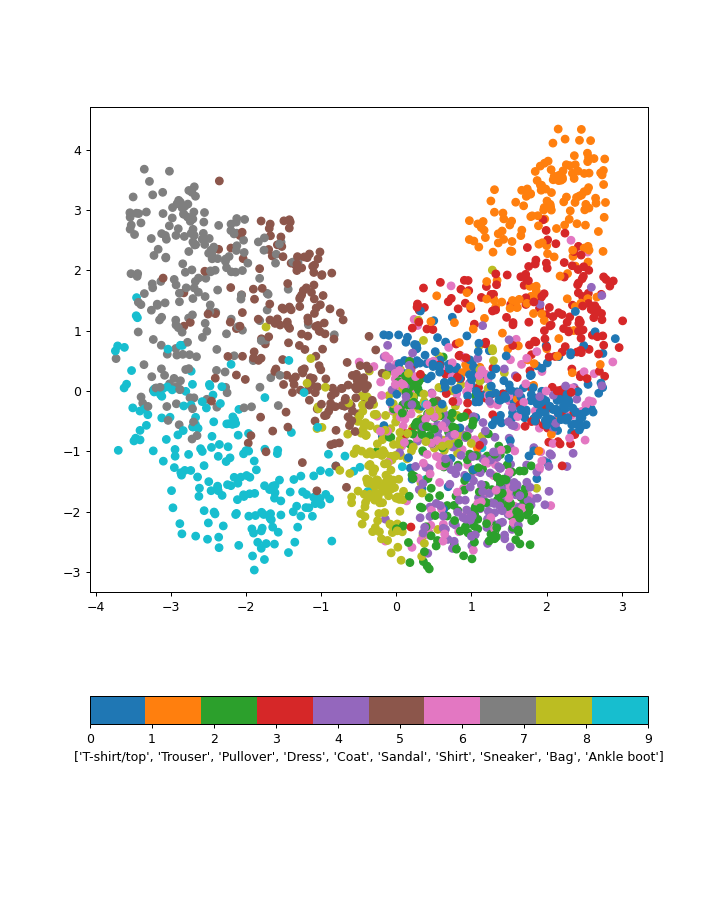

In [14]:
z, z_var = vae.encoder(x_test)
fig = plt.figure('latent space vae', figsize=(8,10))

p = plt.scatter(z[:, 0], z[:, 1], c = y_test, cmap = 'tab10')

cbar = plt.colorbar(p, orientation='horizontal' )
cbar.set_label(list(labeldict.values()))

### Why the result is bad:
* the size of the data is small
* the size of the network is small
* best is to use CNN for images

### Generate from decoder

$$\tilde{x} \sim p(x|z)$$

<IPython.core.display.Javascript object>


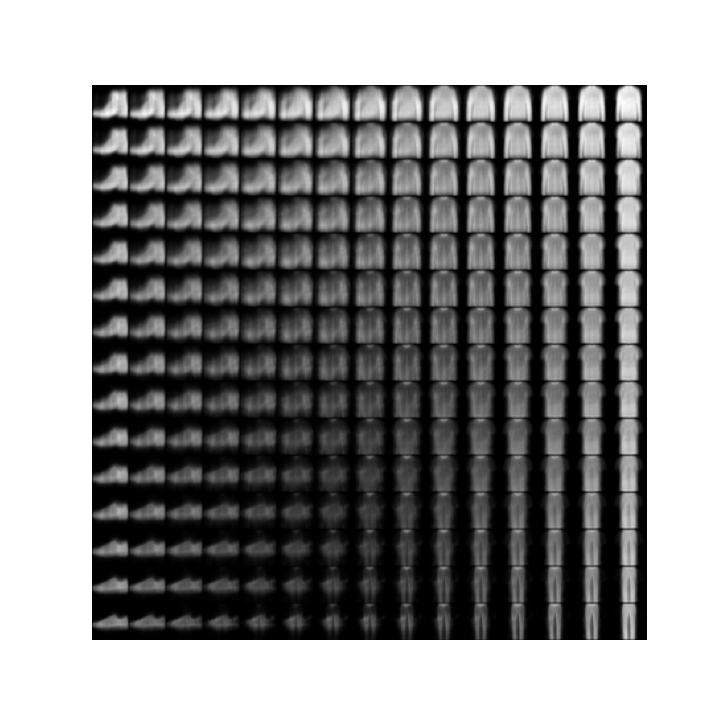

(-0.5, 419.5, 419.5, -0.5)

In [15]:
n = 15 
digit_size = 28

#latent plane
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                                        np.linspace(0.05, 0.95, n)))         
z_grid = norm.ppf(u_grid)
     
x_decoded = vae.decoder(z_grid.reshape(n*n, 2)).mean().numpy()
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure('Samples from generator', figsize=(8, 8))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.axis('off')
 